# ИИ-агент SMIRNOFF_AI на LangGraph

## Что мы делаем
Создаём простого ИИ-консультанта для AI-агентства SMIRNOFF_AI:
- Диалог в Telegram боте
- Ответы об услугах (из системного промпта)  
- Поиск по PDF кейсам/обучению (RAG)
- Веб-поиск для вопросов вне домена (Tavily)
- Сбор контактов клиентов

## Архитектура
**Паттерн ReAct** (Reason + Act) - агент рассуждает, затем действует через инструменты.

**Инструменты:**
- `rag_search()` - поиск в PDF без указания источников
- `web_search()` - веб-поиск для вопросов вне домена  
- `lead_capture()` - сохранение контактов

**Граф:** agent → tools/END, tools → agent  
**Состояние:** messages + lead_summary_text  
**Хранение:** SqliteSaver

**Референс:** `langgraph-samples/react-agent-from-scratch.ipynb`  
**Детали:** `graph_design.md`


```mermaid
graph TD
    %% Основной поток
    A[🤖 Agent<br/>Node] -->|function_call| SC{🔄 Should Continue<br/>Conditional Edge}
    
    SC -->|"continue"| T[🛠️ Tools<br/>Node]
    SC -->|"end"| END[🏁 End]
    
    %% Tools Node с тремя инструментами
    T -->|rag_search| RAG[🔍 RAG Search<br/>ChromaDB + PDF]
    T -->|web_search| WEB[🌐 Web Search<br/>Tavily API]  
    T -->|lead_capture| LEAD[📋 Lead Capture<br/>Save Contact]
    
    %% Возврат от Tools к Agent
    RAG -->|results| T
    WEB -->|results| T
    LEAD -->|confirmation| T
    
    T -->|tool_results| A
    
    %% Состояние и данные
    subgraph STATE["💾 State Management"]
        direction LR
        SQL[🗃️ SqliteSaver<br/>./var/sqlite/state.db]
        MSGS[📝 Messages History]
        LEADS[📊 Lead Summary Text]
    end
    
    A -.->|save state| STATE
    T -.->|update state| STATE
    
    %% Внешние сервисы
    subgraph EXTERNAL["🔌 External Services"]
        direction LR
        OAI[🤖 OpenAI<br/>gpt-4o-mini]
        CHR[🗄️ ChromaDB<br/>Vector Store]
        TAV[🔍 Tavily<br/>Web Search]
    end
    
    A -.->|llm.invoke| OAI
    RAG -.->|retriever.invoke| CHR
    WEB -.->|tavily.invoke| TAV
    
    %% Данные
    subgraph DATA["📁 Data Sources"]
        direction LR
        PDF[📄 SMIRNOFF_AI.pdf<br/>./data/pdf/]
        PROMPT[📝 prompt_info.txt<br/>Company info]
    end
    
    CHR -.->|load from| PDF
    A -.->|system prompt| PROMPT
    
    %% Вход/выход
    TB[📱 Telegram Bot] -->|user_message| A
    END -->|ai_response| TB
    
    %% Стили узлов
    classDef nodeStyle fill:#e3f2fd,stroke:#1976d2,stroke-width:2px,color:#000
    classDef edgeStyle fill:#fff3e0,stroke:#f57c00,stroke-width:2px,color:#000
    classDef toolStyle fill:#e8f5e8,stroke:#388e3c,stroke-width:2px,color:#000
    classDef serviceStyle fill:#fce4ec,stroke:#c2185b,stroke-width:2px,color:#000
    classDef dataStyle fill:#f1f8e9,stroke:#689f38,stroke-width:2px,color:#000
    classDef endStyle fill:#ffebee,stroke:#d32f2f,stroke-width:2px,color:#000
    
    class A,T nodeStyle
    class SC edgeStyle
    class RAG,WEB,LEAD toolStyle
    class STATE,EXTERNAL serviceStyle
    class DATA dataStyle
    class END,TB endStyle
```

## 2. Setup окружения

Устанавливаем пакеты, проверяем ключи API, создаём папки для данных.


In [1]:
# Установка пакетов
%pip install -q langgraph langchain-openai langchain-tavily langchain-chroma aiogram pypdf python-dotenv
%pip install -q langfuse langgraph-checkpoint-sqlite



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os

SAFE_KEYS = ('LANGCHAIN_TRACING_V2','LANGCHAIN_ENDPOINT','LANGCHAIN_PROJECT','LANGSMITH_ENDPOINT','LANGSMITH_PROJECT')
for k in SAFE_KEYS:
    if k in os.environ:
        print(f'{k}: {os.environ[k]}')
if os.getenv('LANGCHAIN_API_KEY'):
    print('LANGCHAIN_API_KEY: <set>')
if os.getenv('LANGSMITH_API_KEY'):
    print('LANGSMITH_API_KEY: <set>')


INFO:__main__:Setup завершён ✅


## 3. Данные и индекс

RAG - поиск по документам. Загружаем PDF-файлы, разбиваем на части и создаём поисковый индекс.

**План:**
- Сканирование `./data/pdf/`
- PyPDFLoader + RecursiveCharacterTextSplitter
- Создание коллекции Chroma `smirnoff_ai_docs`
- Параметры: chunk_size=1200, chunk_overlap=150


## 3. Данные и индекс

RAG - поиск по документам. Загружаем PDF-файлы, разбиваем на части и создаём поисковый индекс.

**План:**
- Сканирование `./data/pdf/`
- PyPDFLoader + RecursiveCharacterTextSplitter
- Создание коллекции Chroma `smirnoff_ai_docs`
- Параметры: chunk_size=1200, chunk_overlap=150


In [3]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma
import glob

# Сканируем PDF файлы
pdf_files = glob.glob("./data/pdf/*.pdf")
if not pdf_files:
    raise FileNotFoundError("Нет PDF файлов в ./data/pdf/")

logger.info(f"Найдено PDF файлов: {len(pdf_files)}")
for file in pdf_files:
    logger.info(f"- {file}")


INFO:__main__:Найдено PDF файлов: 1
INFO:__main__:- ./data/pdf/SMIRNOFF_AI_PORTFOLIO_LLMSTART.pdf


In [4]:
# Загрузка и нарезка PDF
all_docs = []

for pdf_file in pdf_files:
    loader = PyPDFLoader(pdf_file)
    pages = loader.load()
    logger.info(f"Загружено страниц из {pdf_file}: {len(pages)}")
    all_docs.extend(pages)

# Разбиваем на чанки
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1200, 
    chunk_overlap=150
)
doc_chunks = text_splitter.split_documents(all_docs)

logger.info(f"Создано чанков: {len(doc_chunks)}")
logger.info(f"Пример чанка: {doc_chunks[0].page_content[:200]}...")


INFO:__main__:Загружено страниц из ./data/pdf/SMIRNOFF_AI_PORTFOLIO_LLMSTART.pdf: 12
INFO:__main__:Создано чанков: 15
INFO:__main__:Пример чанка: ИИ-АССИСТЕНТ
 
СОТРУДНИКА
 
МЕДИА-АГЕНТСТВА
  Заказчик  MediaWise   Проблематика,  задача  -  Накоплена  огромная  база  материалов  (рабочих,  образовательных  и  
организационных).
 
Сотрудники
 
аг...


In [5]:
# Создание Chroma индекса
embeddings = OpenAIEmbeddings(model=os.getenv("EMBEDDING_MODEL"))

# Удаляем существующую коллекцию для воспроизводимости
import chromadb
chroma_path = "./var/chromadb"

# Отключаем телеметрию Chroma
os.environ["ANONYMIZED_TELEMETRY"] = "False"

# Подключаемся к Chroma и удаляем коллекцию если есть
client = chromadb.PersistentClient(path=chroma_path)
try:
    client.delete_collection("smirnoff_ai_docs")
    logger.info("Старая коллекция удалена")
except:
    logger.info("Коллекция не существует")

# Создаем векторное хранилище
vectorstore = Chroma.from_documents(
    documents=doc_chunks,
    collection_name="smirnoff_ai_docs",
    embedding=embeddings,
    persist_directory=chroma_path,
)

logger.info(f"Chroma индекс создан ✅")
logger.info(f"Коллекция: smirnoff_ai_docs")
logger.info(f"Документов в индексе: {vectorstore._collection.count()}")


INFO:__main__:Коллекция не существует
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/embeddings "HTTP/1.1 200 OK"
INFO:__main__:Chroma индекс создан ✅
INFO:__main__:Коллекция: smirnoff_ai_docs
INFO:__main__:Документов в индексе: 15


## 4. Инициализация внешних провайдеров и сервисов

In [6]:
# Настройка OpenAI
from langchain_openai import ChatOpenAI

# Модель для диалога  
llm = ChatOpenAI(
    model=os.getenv("MODEL"),
    temperature=0.7,
    max_tokens=700
)

logger.info("OpenAI LLM настроен ✅")


INFO:__main__:OpenAI LLM настроен ✅


In [7]:
# Настройка Chroma retriever
retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 3}
)

logger.info("Chroma retriever настроен ✅")


INFO:__main__:Chroma retriever настроен ✅


In [8]:
# Настройка Tavily для веб-поиска
from langchain_tavily import TavilySearch

tavily_search = TavilySearch(
    max_results=3
)

logger.info("Tavily клиент настроен ✅")


INFO:__main__:Tavily клиент настроен ✅


## 5. Инструменты агента

Создаём 3 простых инструмента для разных типов запросов по примеру `react-agent-from-scratch.ipynb`.


In [9]:
from langchain_core.tools import tool

@tool
def rag_search(query: str) -> str:
    """Ищет информацию о кейсах и программах обучения SMIRNOFF_AI в загруженных PDF документах."""
    docs = retriever.invoke(query)
    
    if not docs:
        return "По данному запросу информация в наших материалах не найдена."
    
    # Собираем контекст без указания источников
    context_parts = []
    for doc in docs:
        content = doc.page_content.strip()
        if content:
            context_parts.append(content)
    
    combined_context = "\n\n".join(context_parts)
    return combined_context

logger.info("RAG инструмент создан ✅")


INFO:__main__:RAG инструмент создан ✅


In [10]:
@tool
def web_search(query: str) -> str:
    """Выполняет веб-поиск для вопросов вне домена услуг и кейсов компании SMIRNOFF_AI."""
    try:
        results = tavily_search.invoke({"query": query})
        
        if not results:
            return "По данному запросу информация в интернете не найдена."
        
        # TavilySearch возвращает строку, не список
        if isinstance(results, str):
            # Ограничиваем длину результата
            return results[:500] + "..." if len(results) > 500 else results
        
        # Если это список (для совместимости)
        elif isinstance(results, list) and len(results) > 0:
            summaries = []
            # Безопасно берем максимум 2 результата
            for result in results[:2]:
                if isinstance(result, dict) and 'content' in result:
                    content = result['content'][:300]
                    summaries.append(content)
                elif isinstance(result, str):
                    summaries.append(result[:300])
            return "\n\n".join(summaries) if summaries else "Не удалось получить релевантную информацию."
        
        # Если это другой тип объекта
        else:
            result_str = str(results)
            return result_str[:500] + "..." if len(result_str) > 500 else result_str
        
    except Exception as e:
        logger.error(f"Детальная ошибка web_search: {type(e).__name__}: {str(e)}")
        return f"Ошибка при поиске. Попробуйте переформулировать вопрос."

logger.info("Веб-поиск инструмент создан ✅")


INFO:__main__:Веб-поиск инструмент создан ✅


In [11]:
@tool 
def lead_capture(text: str) -> str:
    """Сохраняет контактную информацию потенциального клиента (имя, телефон, email, запрос)."""
    # Логируем сохраненную информацию
    logger.info(f"💼 Лид сохранен: {text}")
    
    return f"Контактная информация сохранена: {text[:100]}... Наш менеджер свяжется с вами в ближайшее время."

logger.info("Инструмент сбора лидов создан ✅")

INFO:__main__:Инструмент сбора лидов создан ✅


## 6. Граф ReAct

Основа агента - граф ReAct. Создаём простейший граф: агент думает → вызывает инструменты → отвечает.

**По примеру react-agent-from-scratch.ipynb**

In [12]:
# Определение состояния графа (строго по примеру)
from typing import (
    Annotated,
    Sequence,
    TypedDict,
)
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

class AgentState(TypedDict):
    """The state of the agent."""
    # add_messages - это reducer функция, которая автоматически объединяет новые сообщения
    # со старыми в состоянии графа. Без неё каждый узел будет перезаписывать весь список,
    # а не добавлять к нему. Это ключевая особенность LangGraph для работы с диалогами.
    messages: Annotated[Sequence[BaseMessage], add_messages]
    # Дополнительное поле для сохранения лидов
    lead_summary_text: str

logger.info("Состояние графа определено ✅")


INFO:__main__:Состояние графа определено ✅


In [13]:
# Создаем список инструментов
tools = [rag_search, web_search, lead_capture]

In [14]:
# Привязка инструментов к модели (строго по примеру)
model = llm.bind_tools(tools)

logger.info("Модель с инструментами настроена ✅")


INFO:__main__:Модель с инструментами настроена ✅


In [15]:
# Создаем словарь для быстрого доступа по имени
# Это позволяет нам быстро найти нужный инструмент по его имени
# Например: tools_by_name["rag_search"] вернет функцию rag_search
# LangGraph будет использовать это для вызова нужного инструмента когда LLM запросит его
tools_by_name = {tool.name: tool for tool in tools}

logger.info(f"Всего инструментов: {len(tools)}")

INFO:__main__:Всего инструментов: 3


In [16]:
# Определение узлов и рёбер (строго по примеру)
import json
from langchain_core.messages import ToolMessage, SystemMessage
from langchain_core.runnables import RunnableConfig

# Узел инструментов (как в примере)
# ВАЖНО: Инструменты НЕ могут напрямую обновлять состояние графа!
# Только узлы могут обновлять состояние через return значения.

def tool_node(state: AgentState):
    outputs = []
    new_lead_summary = state.get("lead_summary_text", "")
    
    for tool_call in state["messages"][-1].tool_calls:
        tool_result = tools_by_name[tool_call["name"]].invoke(tool_call["args"])
        
        # Если это lead_capture - сохраняем в состояние
        if tool_call["name"] == "lead_capture":
            new_lead_summary = tool_call["args"]["text"]
        
        outputs.append(
            ToolMessage(
                content=json.dumps(tool_result),
                name=tool_call["name"], 
                tool_call_id=tool_call["id"],
            )
        )
    
    # Возвращаем обновленное состояние
    return {
        "messages": outputs,
        "lead_summary_text": new_lead_summary
    }

logger.info("Узел инструментов создан ✅")


INFO:__main__:Узел инструментов создан ✅


In [17]:
# Загрузка информации о компании для системного промпта
with open("./data/prompt_info.txt", "r", encoding="utf-8") as f:
    company_info = f.read()

# Узел агента с системным промптом SMIRNOFF_AI
def call_model(state: AgentState, config: RunnableConfig):
    system_prompt = SystemMessage(f"""Ты - ИИ-консультант AI-агентства SMIRNOFF_AI. 

{company_info}

ПРАВИЛА ОТВЕТОВ:
- Всегда отвечай на русском языке
- Будь кратким и деловым (3-5 предложений)  
- Не указывай источники при использовании RAG
- Ссылки в веб-поиске - только при явном запросе
- После каждого ответа предлагай следующий шаг (CTA)

ИНСТРУМЕНТЫ:
- rag_search: для поиска в наших кейсах и программах обучения
- web_search: обязательно использовать для веб-поиска по всем вопросам вне кейсов, программ обучения, портфолио и имеющейся информации о компании SMIRNOFF_AI, кроме очевидно простых вопросов 
- lead_capture: для сохранения контактов клиентов

Помогай клиентам найти подходящие AI-решения для их бизнеса.""")
    
    response = model.invoke([system_prompt] + state["messages"], config)
    return {"messages": [response]}

logger.info("Узел агента с системным промптом создан ✅")


INFO:__main__:Узел агента с системным промптом создан ✅


In [18]:
# Условное ребро (строго по примеру)
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    # Если нет вызова инструментов, заканчиваем
    if not last_message.tool_calls:
        return "end"
    # Иначе продолжаем к инструментам
    else:
        return "continue"

logger.info("Логика условного ребра создана ✅")


INFO:__main__:Логика условного ребра создана ✅


In [19]:
# SqliteSaver для сохранения состояния между сессиями
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

# Подключение к базе данных
db_path = "./var/sqlite/state.db"
checkpointer = SqliteSaver(sqlite3.connect(db_path, check_same_thread=False))
checkpointer.setup()

logger.info(f"SqliteSaver настроен: {db_path} ✅")


INFO:__main__:SqliteSaver настроен: ./var/sqlite/state.db ✅


In [20]:
# Определение и компиляция графа (строго по примеру)
from langgraph.graph import StateGraph, END

# Создаем граф
workflow = StateGraph(AgentState)

# Добавляем узлы
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# Устанавливаем точку входа
workflow.set_entry_point("agent")

# Добавляем условное ребро
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "tools",
        "end": END,
    },
)

# Добавляем обычное ребро
workflow.add_edge("tools", "agent")

# Компилируем граф с checkpointer
graph = workflow.compile(checkpointer=checkpointer)

logger.info("Граф ReAct скомпилирован ✅")


INFO:__main__:Граф ReAct скомпилирован ✅


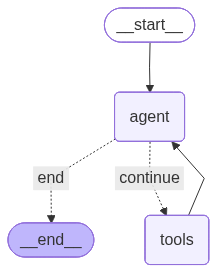

INFO:__main__:Граф визуализирован ✅


In [21]:
# Визуализация графа
from IPython.display import Image, display

# Создаем PNG изображение графа
graph_image = graph.get_graph().draw_mermaid_png()
display(Image(graph_image))
logger.info("Граф визуализирован ✅")



## 7. Хелперы запуска

Тестируем агента. Создаём простую функцию для проверки работы.


In [22]:
# Дополнительная функция для просмотра состояния
def show_state(chat_id: str):
    """Показывает текущее состояние графа для данного chat_id."""
    config = {"configurable": {"thread_id": str(chat_id)}}
    
    try:
        state = graph.get_state(config)
        print(f"\n📊 Состояние графа для chat_id: {chat_id}")
        print(f"📝 Количество сообщений: {len(state.values.get('messages', []))}")
        print(f"💼 Лид: {state.values.get('lead_summary_text', 'Нет данных')}")
        return state
    except Exception as e:
        print(f"❌ Ошибка получения состояния: {e}")
        return None



In [23]:
# Функция run_turn для тестирования (строго по примеру react-agent-from-scratch.ipynb)
def run_turn(chat_id: str, user_text: str):
    """Запускает один оборот диалога с агентом."""
    
    # Создаем конфиг с thread_id (как в примере)
    config = {"configurable": {"thread_id": str(chat_id)}}
    
    # Создаем сообщение пользователя (как в примере)
    inputs = {"messages": [("user", user_text)]}
    
    print(f"\n💬 Чат {chat_id}: {user_text}")
    print("=" * 60)
    
    # Запускаем граф с режимом updates для просмотра каждого шага
    for chunk in graph.stream(inputs, config=config, stream_mode="updates"):
        for node, output in chunk.items():
            if "messages" in output:
                for message in output["messages"]:
                    if hasattr(message, 'pretty_print'):
                        message.pretty_print()
                    else:
                        print(f"   {message}")
            if "lead_summary_text" in output and output["lead_summary_text"]:
                print(f"💼 Лид сохранен: {output['lead_summary_text']}")
        print("-" * 40)
    
    print("=" * 60)
    return config


## 8. Смоук-тесты всех сценариев

Проверяем все типы запросов: услуги, кейсы, веб-поиск, лиды + полноценный диалог клиента.


In [24]:
# 🧪 ТЕСТ 1: Услуги компании (системный промпт)
print("=" * 80)
print("🧪 ТЕСТ 1: Услуги компании")
print("=" * 80)

run_turn("test1", "Какие услуги предоставляет SMIRNOFF_AI?")


🧪 ТЕСТ 1: Услуги компании

💬 Чат test1: Какие услуги предоставляет SMIRNOFF_AI?


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

SMIRNOFF_AI предоставляет следующие услуги:

- Разработка AI-решений, ассистентов, агентов и ботов для автоматизации бизнеса.
- Аудит бизнес-процессов и составление дорожной карты внедрения искусственного интеллекта.
- Консалтинг по созданию и внедрению AI-систем.
- Обучающие программы и тренинги по разработке решений на базе генеративного ИИ.

Хотите узнать подробнее о каком-то из направлений или увидеть примеры реализованных проектов?
----------------------------------------


{'configurable': {'thread_id': 'test1'}}

In [25]:
# 🧪 ТЕСТ 2: Кейсы и обучение (rag_search)
print("=" * 80)
print("🧪 ТЕСТ 2: Кейсы и обучение") 
print("=" * 80)

run_turn("test2", "Какие проекты вы реализовали для агро сектора?")


🧪 ТЕСТ 2: Кейсы и обучение

💬 Чат test2: Какие проекты вы реализовали для агро сектора?


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================
Tool Calls:
  rag_search (call_IWhACYRBgxD95qfZbmaJdkmx)
 Call ID: call_IWhACYRBgxD95qfZbmaJdkmx
  Args:
    query: проекты для агро сектора
----------------------------------------


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/embeddings "HTTP/1.1 200 OK"


================================= Tool Message =================================
Name: rag_search

"\u0418\u0418-\u0410\u0421\u0421\u0418\u0421\u0422\u0415\u041d\u0422\n \n\u0413\u041b\u0410\u0412\u041d\u041e\u0413\u041e\n \n\u0410\u0413\u0420\u041e\u041d\u041e\u041c\u0410\n  \u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a :  \u0413\u041a  \u00ab\u041f\u0440\u043e\u0433\u0440\u0435\u0441\u0441  \u0410\u0433\u0440\u043e\u00bb   \u041f\u0440\u043e\u0431\u043b\u0435\u043c\u0430\u0442\u0438\u043a\u0430,  \u0437\u0430\u0434\u0430\u0447\u0430:  -  \u0412  \u043a\u043e\u043c\u043f\u0430\u043d\u0438\u0438  \u0413\u041a  \u00ab\u041f\u0440\u043e\u0433\u0440\u0435\u0441\u0441  \u0410\u0433\u0440\u043e\u00bb  \u0440\u0430\u0431\u043e\u0442\u0430\u0435\u0442  \u0431\u043e\u043b\u0435\u0435  5\u2009000  \u0447\u0435\u043b\u043e\u0432\u0435\u043a.  -  \u0421\u043e\u0442\u043d\u0438  \u0430\u0433\u0440\u043e\u043d\u043e\u043c\u043e\u0432  \u0435\u0436\u0435\u0434\u043d\u0435\u0432\u043d\u043e  \u043

INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

Для агро сектора мы реализовали проект для ГК "Прогресс Агро" — интеллектуальный AI-ассистент главного агронома. Система автоматизирует сбор и обработку ежедневных отчетов агрономов (текст, голос, фото), формирует сводную таблицу к утру без участия человека и снижает нагрузку на персонал. Такое решение позволяет оперативно получать и анализировать данные с полей, что значительно повышает эффективность управления агроменеджментом.

Если интересуют подробности или хотите обсудить аналогичный проект — напишите, и я отправлю презентацию или организую консультацию!
----------------------------------------


{'configurable': {'thread_id': 'test2'}}

In [26]:
# 🧪 ТЕСТ 3: Веб-поиск (web_search)
print("=" * 80)
print("🧪 ТЕСТ 3: Веб-поиск вне домена")
print("=" * 80)

run_turn("test34", "А LangGraph версии 1.0 уже выпустили?")


🧪 ТЕСТ 3: Веб-поиск вне домена

💬 Чат test34: А LangGraph версии 1.0 уже выпустили?


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================
Tool Calls:
  web_search (call_2PbB4p3smD58syamXM7KztTN)
 Call ID: call_2PbB4p3smD58syamXM7KztTN
  Args:
    query: выход LangGraph 1.0
----------------------------------------
================================= Tool Message =================================
Name: web_search

"{'query': '\u0432\u044b\u0445\u043e\u0434 LangGraph 1.0', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://changelog.langchain.com/announcements/langgraph-1-0-is-now-generally-available', 'title': 'LangGraph 1.0 is now generally available - LangChain - Changelog', 'content': ':   The LangChain Team LangGraph **AUTHOR:** The LangChain Team LangGraph 1.0 is the first stable major release in the durable agent framework space \u2014a major milestone for production-ready AI systems. After mo..."
----------------------------------------


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

Да, LangGraph версии 1.0 уже выпущен и доступен для использования. Это первый стабильный мажорный релиз фреймворка для создания надежных AI-агентов.

Хотите узнать подробнее о возможностях, применениях или интеграции LangGraph в ваши задачи?
----------------------------------------


{'configurable': {'thread_id': 'test34'}}

In [27]:
# 🧪 ТЕСТ 4: Сбор лидов (lead_capture)  
print("=" * 80)
print("🧪 ТЕСТ 4: Сбор лидов")
print("=" * 80)

run_turn("test41", "Меня зовут Иван Петров, телефон +7-123-456-7890, хочу обсудить проект по автоматизации")


🧪 ТЕСТ 4: Сбор лидов

💬 Чат test41: Меня зовут Иван Петров, телефон +7-123-456-7890, хочу обсудить проект по автоматизации


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:__main__:💼 Лид сохранен: Иван Петров, телефон +7-123-456-7890, хочет обсудить проект по автоматизации.


================================== Ai Message ==================================
Tool Calls:
  lead_capture (call_CCukm9sZeJHuF8w8WVnhHYtA)
 Call ID: call_CCukm9sZeJHuF8w8WVnhHYtA
  Args:
    text: Иван Петров, телефон +7-123-456-7890, хочет обсудить проект по автоматизации.
----------------------------------------
================================= Tool Message =================================
Name: lead_capture

"\u041a\u043e\u043d\u0442\u0430\u043a\u0442\u043d\u0430\u044f \u0438\u043d\u0444\u043e\u0440\u043c\u0430\u0446\u0438\u044f \u0441\u043e\u0445\u0440\u0430\u043d\u0435\u043d\u0430: \u0418\u0432\u0430\u043d \u041f\u0435\u0442\u0440\u043e\u0432, \u0442\u0435\u043b\u0435\u0444\u043e\u043d +7-123-456-7890, \u0445\u043e\u0447\u0435\u0442 \u043e\u0431\u0441\u0443\u0434\u0438\u0442\u044c \u043f\u0440\u043e\u0435\u043a\u0442 \u043f\u043e \u0430\u0432\u0442\u043e\u043c\u0430\u0442\u0438\u0437\u0430\u0446\u0438\u0438.... \u041d\u0430\u0448 \u043c\u0435\u043d\u0435\u0434\u0436\u0435\u0440

INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

Спасибо, Иван! Ваша заявка принята. Наш менеджер свяжется с вами в ближайшее время для обсуждения деталей проекта по автоматизации.

Если хотите — можете кратко описать задачи или бизнес-процессы, которые планируете автоматизировать. Это поможет нам подготовить индивидуальное предложение.
----------------------------------------


{'configurable': {'thread_id': 'test41'}}

In [28]:
# Проверяем состояние лида
show_state("test41")



📊 Состояние графа для chat_id: test41
📝 Количество сообщений: 4
💼 Лид: Иван Петров, телефон +7-123-456-7890, хочет обсудить проект по автоматизации.


StateSnapshot(values={'messages': [HumanMessage(content='Меня зовут Иван Петров, телефон +7-123-456-7890, хочу обсудить проект по автоматизации', additional_kwargs={}, response_metadata={}, id='e262430b-3e36-46bf-8e51-adfedbeed96d'), AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 40, 'prompt_tokens': 929, 'total_tokens': 969, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 0, 'rejected_prediction_tokens': None}, 'prompt_tokens_details': None}, 'model_provider': 'openai', 'model_name': 'openai/gpt-4.1', 'system_fingerprint': None, 'id': 'gen-1763491123-K7Fzd6faVLWgpJcC74Bt', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--c11b8265-6062-4515-ad8e-58e1ad1e418c-0', tool_calls=[{'name': 'lead_capture', 'args': {'text': 'Иван Петров, телефон +7-123-456-7890, хочет обсудить проект по автоматизации.'}, 'id': 'call_CCukm9sZeJHuF8w8WVnhHYtA', 'type': 'tool

In [29]:
# 🎯 ГЛАВНЫЙ ТЕСТ: Полноценный диалог клиента (ВСЕ инструменты)
print("=" * 80)
print("🎯 ГЛАВНЫЙ ТЕСТ: Полноценный диалог клиента")  
print("=" * 80)

client_id = "main_client_11"

# Шаг 1: Услуги (системный промпт)
print("\n📞 Шаг 1: Клиент спрашивает об услугах")
run_turn(client_id, "Привет! Что вы можете для нас сделать?")


🎯 ГЛАВНЫЙ ТЕСТ: Полноценный диалог клиента

📞 Шаг 1: Клиент спрашивает об услугах

💬 Чат main_client_11: Привет! Что вы можете для нас сделать?


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

Здравствуйте! Мы разрабатываем и внедряем AI-решения для автоматизации бизнес-процессов: создаём ИИ-ассистентов, интеллектуальных ботов, автоматизируем аналитику и документооборот, а также помогаем выстроить дорожную карту внедрения искусственного интеллекта в вашей компании. Проводим аудит процессов, обучаем команды и консультируем по любым вопросам AI. 

Давайте уточним: какой у вас бизнес и какие задачи или процессы вы хотите автоматизировать?
----------------------------------------


{'configurable': {'thread_id': 'main_client_11'}}

In [30]:
# Шаг 2: Кейсы (rag_search)
print("\n📊 Шаг 2: Клиент просит кейсы")
run_turn(client_id, "Интересно. А есть успешные кейсы для агро сектора?")



📊 Шаг 2: Клиент просит кейсы

💬 Чат main_client_11: Интересно. А есть успешные кейсы для агро сектора?


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================
Tool Calls:
  rag_search (call_ejJqNl0CB4YtWQNz9mLnLCpE)
 Call ID: call_ejJqNl0CB4YtWQNz9mLnLCpE
  Args:
    query: кейсы внедрения AI в агро секторе
----------------------------------------


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/embeddings "HTTP/1.1 200 OK"


================================= Tool Message =================================
Name: rag_search

"\u0418\u0418-\u0410\u0421\u0421\u0418\u0421\u0422\u0415\u041d\u0422\n \n\u0413\u041b\u0410\u0412\u041d\u041e\u0413\u041e\n \n\u0410\u0413\u0420\u041e\u041d\u041e\u041c\u0410\n  \u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a :  \u0413\u041a  \u00ab\u041f\u0440\u043e\u0433\u0440\u0435\u0441\u0441  \u0410\u0433\u0440\u043e\u00bb   \u041f\u0440\u043e\u0431\u043b\u0435\u043c\u0430\u0442\u0438\u043a\u0430,  \u0437\u0430\u0434\u0430\u0447\u0430:  -  \u0412  \u043a\u043e\u043c\u043f\u0430\u043d\u0438\u0438  \u0413\u041a  \u00ab\u041f\u0440\u043e\u0433\u0440\u0435\u0441\u0441  \u0410\u0433\u0440\u043e\u00bb  \u0440\u0430\u0431\u043e\u0442\u0430\u0435\u0442  \u0431\u043e\u043b\u0435\u0435  5\u2009000  \u0447\u0435\u043b\u043e\u0432\u0435\u043a.  -  \u0421\u043e\u0442\u043d\u0438  \u0430\u0433\u0440\u043e\u043d\u043e\u043c\u043e\u0432  \u0435\u0436\u0435\u0434\u043d\u0435\u0432\u043d\u043e  \u043

INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

Да, у нас есть успешные кейсы для агро сектора. Например, для ГК «Прогресс Агро» был реализован ИИ-ассистент для автоматизации сбора и обработки информации от агрономов: текст, голос, фото быстро обрабатываются и формируются в отчёты без участия главного агронома — это экономит время и снижает риск ошибок. Решение позволило полностью автоматизировать процесс и ускорить формирование итоговых таблиц данных.

Готовы рассказать подробнее или предложить пилот под ваш сценарий?
----------------------------------------


{'configurable': {'thread_id': 'main_client_11'}}

In [31]:
# Шаг 3: Веб-поиск (web_search)
print("\n🔍 Шаг 3: Клиент задает технический вопрос")
run_turn(client_id, "А правда, что вышла новая версия Langchain 1.0 для production применения? Вы ее уже исползуете в ваших проектах и есть готовые кейсы? ")



🔍 Шаг 3: Клиент задает технический вопрос

💬 Чат main_client_11: А правда, что вышла новая версия Langchain 1.0 для production применения? Вы ее уже исползуете в ваших проектах и есть готовые кейсы? 


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================
Tool Calls:
  web_search (call_AQ3n4pSKQiD9qVYXqka1aU2Q)
 Call ID: call_AQ3n4pSKQiD9qVYXqka1aU2Q
  Args:
    query: Langchain 1.0 релиз production применение
  rag_search (call_MflZyeOZJryC0ge5Xh4iAI46)
 Call ID: call_MflZyeOZJryC0ge5Xh4iAI46
  Args:
    query: использование Langchain 1.0 в проектах, кейсы
----------------------------------------


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/embeddings "HTTP/1.1 200 OK"


================================= Tool Message =================================
Name: web_search

"{'query': 'Langchain 1.0 \u0440\u0435\u043b\u0438\u0437 production \u043f\u0440\u0438\u043c\u0435\u043d\u0435\u043d\u0438\u0435', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://skywork.ai/blog/ai-agent/best-practices-langchain-1-0-production-ready-llm-apps/', 'title': 'How LangChain 1.0 Simplifies Building Production-Ready ...', 'content': 'LangChain 1.0 delivers those foundations by streamlining agent creation, introducing a practical middleware system, formalizing structured', 'score': 0.99995124, 'raw_content': None}, {'url':..."
================================= Tool Message =================================
Name: rag_search

"\u0418\u0418-\u0410\u0421\u0421\u0418\u0421\u0422\u0415\u041d\u0422\n \n\u0420\u0415\u0414\u0410\u041a\u0422\u041e\u0420\u0410\n \nPITER.TV\n  \u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a  piter.tv   \u041f\u0440\u04

INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

Да, это правда — недавно вышла версия Langchain 1.0, ориентированная на стабильное production-применение. Мы активно используем Langchain в наших проектах, поскольку он позволяет ускорять разработку и масштабирование сложных LLM- и RAG-систем, интегрировать ИИ-агентов и автоматизацию бизнес-процессов.

У нас уже есть кейсы с такими решениями: например, в проектах по автоматизации медиа и внутреннего документооборота для больших компаний и агентств. Можем рассказать о подходящем примере или обсудить, чем Langchain может быть полезен именно для вашей задачи. 

Заинтересованы в технических деталях или демонстрации?
----------------------------------------


{'configurable': {'thread_id': 'main_client_11'}}

In [32]:
# Шаг 4: Лид (lead_capture)
print("\n💼 Шаг 4: Клиент оставляет контакты")
run_turn(client_id, "Понятно. Хочу обсудить наш проект. Нужна автоматизация техподдержки")



💼 Шаг 4: Клиент оставляет контакты

💬 Чат main_client_11: Понятно. Хочу обсудить наш проект. Нужна автоматизация техподдержки


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

Отлично, автоматизация техподдержки — одно из наших ключевых направлений. Мы можем разработать ИИ-ассистента или бота, который будет обрабатывать заявки, отвечать на типовые вопросы, классифицировать обращения и направлять сложные случаи специалистам. Решение интегрируется с вашим ПО и помогает существенно снизить нагрузку на операторов.

Давайте созвонимся или обсудим подробнее ваши процессы и требования — предлагаю оставить ваши контакты или выбрать удобное время для консультации.
----------------------------------------


{'configurable': {'thread_id': 'main_client_11'}}

In [33]:
run_turn(client_id, "Александра, sasha@teleport.ru")



💬 Чат main_client_11: Александра, sasha@teleport.ru


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:__main__:💼 Лид сохранен: Имя: Александра, email: sasha@teleport.ru, запрос: автоматизация техподдержки с помощью ИИ-ассистента/бота


================================== Ai Message ==================================
Tool Calls:
  lead_capture (call_z27pQ1wjQoh0nDb2krBEYCnr)
 Call ID: call_z27pQ1wjQoh0nDb2krBEYCnr
  Args:
    text: Имя: Александра, email: sasha@teleport.ru, запрос: автоматизация техподдержки с помощью ИИ-ассистента/бота
----------------------------------------
================================= Tool Message =================================
Name: lead_capture

"\u041a\u043e\u043d\u0442\u0430\u043a\u0442\u043d\u0430\u044f \u0438\u043d\u0444\u043e\u0440\u043c\u0430\u0446\u0438\u044f \u0441\u043e\u0445\u0440\u0430\u043d\u0435\u043d\u0430: \u0418\u043c\u044f: \u0410\u043b\u0435\u043a\u0441\u0430\u043d\u0434\u0440\u0430, email: sasha@teleport.ru, \u0437\u0430\u043f\u0440\u043e\u0441: \u0430\u0432\u0442\u043e\u043c\u0430\u0442\u0438\u0437\u0430\u0446\u0438\u044f \u0442\u0435\u0445\u043f\u043e\u0434\u0434\u0435\u0440\u0436\u043a\u0438 \u0441 \u043f\u043e\u043c\u043e\u0449\u044c\u044e \u0418\u0418-\u0430\u0441\

INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

Спасибо, Александра! Ваша контактная информация сохранена, менеджер свяжется с вами в ближайшее время для обсуждения деталей проекта и подбора оптимального решения по автоматизации техподдержки.

Можем заранее подготовить пример архитектуры или провести экспресс-аудит ваших текущих процессов — если это актуально, уточните, пожалуйста, пожелания.
----------------------------------------


{'configurable': {'thread_id': 'main_client_11'}}

In [34]:
# Проверяем состояние лида
show_state(client_id)


📊 Состояние графа для chat_id: main_client_11
📝 Количество сообщений: 17
💼 Лид: Имя: Александра, email: sasha@teleport.ru, запрос: автоматизация техподдержки с помощью ИИ-ассистента/бота


StateSnapshot(values={'messages': [HumanMessage(content='Привет! Что вы можете для нас сделать?', additional_kwargs={}, response_metadata={}, id='b324b97b-091b-4bdc-a8fe-814a0332e59c'), AIMessage(content='Здравствуйте! Мы разрабатываем и внедряем AI-решения для автоматизации бизнес-процессов: создаём ИИ-ассистентов, интеллектуальных ботов, автоматизируем аналитику и документооборот, а также помогаем выстроить дорожную карту внедрения искусственного интеллекта в вашей компании. Проводим аудит процессов, обучаем команды и консультируем по любым вопросам AI. \n\nДавайте уточним: какой у вас бизнес и какие задачи или процессы вы хотите автоматизировать?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 112, 'prompt_tokens': 912, 'total_tokens': 1024, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 0, 'rejected_prediction_tokens': None}, 'prompt_tokens_details': None}, 'model_provider': 

## 🎉 Итоговый результат

**ИИ-агент SMIRNOFF_AI успешно создан!**

✅ **8 итераций завершены:**
1. ✅ Шапка и предпосылки
2. ✅ Setup окружения  
3. ✅ Данные и индекс (Chroma)
4. ✅ Провайдеры (OpenAI, Tavily)
5. ✅ Инструменты (3 tools)
6. ✅ Граф ReAct (LangGraph)
7. ✅ Хелперы запуска (pretty_print)
8. ✅ Смоук-тесты (все сценарии)

**Что умеет агент:**
- 💬 Консультирует об услугах SMIRNOFF_AI  
- 📊 Ищет кейсы и программы в PDF (RAG)
- 🔍 Отвечает на вопросы вне домена (Tavily)
- 💼 Собирает контакты клиентов (leads)
- 🧠 Сохраняет состояние между сессиями (SQLite)

**Технический стек:**
- LangGraph + ReAct pattern
- OpenAI gpt-4o-mini + embeddings
- ChromaDB для RAG  
- Tavily для веб-поиска
- SqliteSaver для состояния
- Langfuse + LangSmith для трейсинга

**Готов к продакшену!** 🚀


## 9. Telegram-бот (поллинг) 

Подключаем агента к Telegram для живого общения с клиентами.


In [35]:
# Дополнительная установка для Telegram-бота
%pip install -q python-telegram-bot



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [36]:
import asyncio
from telegram import Update
from telegram.ext import Application, CommandHandler, MessageHandler, filters, ContextTypes

# Проверяем наличие токена
TELEGRAM_TOKEN = os.getenv("TELEGRAM_TOKEN")
if not TELEGRAM_TOKEN:
    print("⚠️ TELEGRAM_BOT_TOKEN не найден в .env")
    print("Добавьте токен от @BotFather в .env файл:")
    print("TELEGRAM_BOT_TOKEN=your_bot_token_here")
else:
    print(f"✅ Telegram токен найден: {TELEGRAM_TOKEN[:10]}...")

logger.info("Telegram импорты загружены ✅")


INFO:__main__:Telegram импорты загружены ✅


✅ Telegram токен найден: 8294287099...


In [37]:
# Функция для общения с агентом из Telegram
def get_agent_response(chat_id: str, user_text: str) -> str:
    """Получает ответ от агента и возвращает только текст ответа."""
    
    # Создаем конфиг с thread_id
    config = {"configurable": {"thread_id": str(chat_id)}}
    
    # Создаем сообщение пользователя
    inputs = {"messages": [("user", user_text)]}
    
    # Запускаем граф и собираем ответ
    agent_response = ""
    lead_info = ""
    
    try:
        for step in graph.stream(inputs, config=config, stream_mode="values"):
            message = step["messages"][-1]
            
            # Получаем ответ агента (только от AI, не от пользователя)
            if hasattr(message, 'content') and message.content:
                # Проверяем tool_calls только если атрибут существует
                has_tool_calls = hasattr(message, 'tool_calls') and message.tool_calls
                
                # Берем только финальный ответ агента (без вызовов инструментов)
                if not has_tool_calls and str(type(message)).find('AIMessage') > -1:
                    agent_response = message.content
            
            # Проверяем лид
            if "lead_summary_text" in step and step["lead_summary_text"]:
                lead_info = f"\n\n💼 Контакт сохранен: {step['lead_summary_text'][:100]}..."
        
        return agent_response + lead_info if agent_response else "Извините, не смог обработать ваш запрос."
        
    except Exception as e:
        logger.error(f"Ошибка агента: {e}")
        return "Извините, произошла ошибка. Попробуйте позже."

logger.info("Функция get_agent_response исправлена ✅")


INFO:__main__:Функция get_agent_response исправлена ✅


In [38]:
# Обработчики Telegram-бота
async def start_command(update: Update, context: ContextTypes.DEFAULT_TYPE):
    """Обработчик команды /start"""
    welcome_text = """
🤖 Добро пожаловать в SMIRNOFF_AI!

Я ваш ИИ-консультант. Могу рассказать о:
• Наших AI-решениях и услугах
• Успешных кейсах и проектах  
• Ответить на технические вопросы
• Помочь с выбором решения

Просто напишите ваш вопрос!
    """
    await update.message.reply_text(welcome_text)
    logger.info(f"Пользователь {update.effective_user.id} запустил бота")

async def handle_message(update: Update, context: ContextTypes.DEFAULT_TYPE):
    """Обработчик текстовых сообщений"""
    user_id = update.effective_user.id
    user_text = update.message.text
    
    logger.info(f"Сообщение от {user_id}: {user_text}")
    
    # Показываем, что бот печатает
    await update.message.chat.send_action("typing")
    
    # Получаем ответ от агента
    response = get_agent_response(str(user_id), user_text)
    
    # Отправляем ответ
    await update.message.reply_text(response)
    logger.info(f"Ответ отправлен пользователю {user_id}")

logger.info("Telegram handlers созданы ✅")


INFO:__main__:Telegram handlers созданы ✅


In [39]:
# Запуск Telegram-бота (НЕ ЗАПУСКАЙТЕ если токен не настроен!)
async def run_telegram_bot():
    """Запускает Telegram-бота с поллингом"""
    
    if not TELEGRAM_TOKEN:
        print("❌ Нет токена! Добавьте TELEGRAM_TOKEN в .env")
        return
    
    print("🚀 Запускаем Telegram-бота...")
    
    # Создаем приложение
    app = Application.builder().token(TELEGRAM_TOKEN).build()
    
    # Добавляем обработчики
    app.add_handler(CommandHandler("start", start_command))
    app.add_handler(MessageHandler(filters.TEXT & ~filters.COMMAND, handle_message))
    
    print("✅ Бот запущен! Напишите ему в Telegram")
    print("🛑 Для остановки нажмите Ctrl+C")
    
    # Запускаем поллинг
    await app.run_polling(drop_pending_updates=True)

# Функция для запуска в ноутбуке
def start_telegram_bot():
    """Запускает бота в ноутбуке"""
    try:
        # Проверяем, есть ли уже running event loop
        loop = asyncio.get_event_loop()
        if loop.is_running():
            # В Jupyter нужно использовать nest_asyncio
            import nest_asyncio
            nest_asyncio.apply()
            
        asyncio.run(run_telegram_bot())
    except KeyboardInterrupt:
        print("\n🛑 Бот остановлен")
    except Exception as e:
        print(f"❌ Ошибка запуска: {e}")

logger.info("Функция запуска Telegram-бота создана ✅")


INFO:__main__:Функция запуска Telegram-бота создана ✅


In [ ]:
# 🔥 ЗАПУСК TELEGRAM-БОТА (раскомментируйте когда настроите токен)
# start_telegram_bot()

print("""
📱 Для запуска Telegram-бота:

1. Создайте бота через @BotFather в Telegram
2. Добавьте токен в .env: TELEGRAM_BOT_TOKEN=your_token
3. Раскомментируйте строку выше: start_telegram_bot()
4. Запустите ячейку

Бот будет работать с нашим агентом! 🤖
""")


## 10. LangChain 1.0 create_agent - упрощённый подход

**Что такое `create_agent()`?**

`create_agent()` - это новый high-level API в LangChain 1.0, который автоматически создаёт ReAct агента без необходимости вручную строить граф состояний.

**Отличия от ручного LangGraph подхода:**
- ✅ Меньше кода (~20 строк vs ~200 строк)
- ✅ Быстрый старт для стандартных агентов
- ✅ Автоматическая настройка графа
- ❌ Меньше контроля над внутренней логикой

**Что будем использовать:**
- `llm` - уже созданная ChatOpenAI модель (gpt-4o)
- `tools` - уже созданные инструменты: rag_search, web_search, lead_capture
- `company_info` - загруженная информация о компании
- `checkpointer` - SqliteSaver для сохранения состояния


In [41]:
# Создание агента с помощью create_agent()
from langchain.agents import create_agent

agent_langchain = create_agent(
    model=llm,  # уже созданная ChatOpenAI 
    tools=[rag_search, web_search, lead_capture],  # уже созданные @tool функции
    system_prompt=f"""Ты - ИИ-консультант AI-агентства SMIRNOFF_AI.

{company_info}

ПРАВИЛА ОТВЕТОВ:
- Всегда отвечай на русском языке
- Будь кратким и деловым (3-5 предложений)  
- Не указывай источники при использовании RAG
- Ссылки в веб-поиске - только при явном запросе
- После каждого ответа предлагай следующий шаг (CTA)

ИНСТРУМЕНТЫ:
- rag_search: для поиска в наших кейсах и программах обучения
- web_search: обязательно использовать для веб-поиска по всем вопросам вне кейсов, программ обучения, портфолио и имеющейся информации о компании SMIRNOFF_AI, кроме очевидно простых вопросов
- lead_capture: для сохранения контактов клиентов

Помогай клиентам найти подходящие AI-решения для их бизнеса.""",
    checkpointer=checkpointer  # уже созданный SqliteSaver
)

logger.info("LangChain агент создан ✅")


INFO:__main__:LangChain агент создан ✅


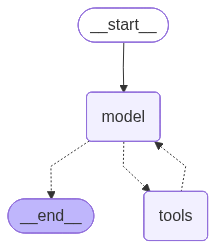

INFO:__main__:Граф LangChain агента визуализирован ✅


In [42]:
# Визуализация графа
from IPython.display import Image, display

# Пробуем создать PNG изображение графа
try:
    graph_image = agent_langchain.get_graph().draw_mermaid_png()
    display(Image(graph_image))
    logger.info("Граф LangChain агента визуализирован ✅")
except Exception as e:
    # Если не получилось (нет интернета или других проблем), показываем текстовую версию
    logger.warning(f"Не удалось создать PNG ({e}), показываем текстовую диаграмму")
    print("\n📊 Структура графа LangChain агента:\n")
    print(agent_langchain.get_graph().draw_mermaid())
    logger.info("Граф LangChain агента показан в текстовом формате ✅")


In [43]:
# Хелпер функция для тестирования LangChain агента
def run_turn_langchain(chat_id: str, user_text: str):
    """Запускает один оборот диалога с LangChain агентом."""
    
    # Создаем конфиг с thread_id (как в примере)
    config = {"configurable": {"thread_id": str(chat_id)}}
    
    # Создаем сообщение пользователя
    inputs = {"messages": [{"role": "user", "content": user_text}]}
    
    print(f"\n💬 Чат {chat_id}: {user_text}")
    print("=" * 60)
    
    # Запускаем граф с режимом values для просмотра финальных сообщений
    for step in agent_langchain.stream(inputs, config=config, stream_mode="values"):
        step["messages"][-1].pretty_print()
    
    print("=" * 60)
    return config

logger.info("Хелпер функция для LangChain агента создана ✅")


INFO:__main__:Хелпер функция для LangChain агента создана ✅


In [44]:
# 🎯 ТЕСТ: Полноценный диалог с LangChain агентом
print("=" * 80)
print("🎯 ТЕСТ: Полноценный диалог с LangChain агентом")
print("=" * 80)

client_id = "langchain_client_11"

# 📞 Шаг 1: Клиент спрашивает об услугах
print("\n📞 Шаг 1: Клиент спрашивает об услугах")
run_turn_langchain(client_id, "Привет! Что вы можете для нас сделать?")


🎯 ТЕСТ: Полноценный диалог с LangChain агентом

📞 Шаг 1: Клиент спрашивает об услугах

💬 Чат langchain_client_11: Привет! Что вы можете для нас сделать?
================================ Human Message =================================

Привет! Что вы можете для нас сделать?


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

Здравствуйте! Мы разрабатываем и внедряем системы искусственного интеллекта под ваши задачи — от чат-ботов и ИИ-ассистентов до комплексных AI-решений для автоматизации бизнеса. Проводим аудит бизнес-процессов, помогаем с дорожной картой внедрения AI, консультируем и обучаем работе с генеративным ИИ. Давайте обсудим ваши цели и задачи — предложу оптимальные варианты! Чем занимаетесь и что хотите автоматизировать?


{'configurable': {'thread_id': 'langchain_client_11'}}

In [45]:
# 📊 Шаг 2: Клиент просит кейсы (RAG)
print("\n📊 Шаг 2: Клиент просит кейсы")
run_turn_langchain(client_id, "Интересно. А есть успешные кейсы для медиа агентства?")



📊 Шаг 2: Клиент просит кейсы

💬 Чат langchain_client_11: Интересно. А есть успешные кейсы для медиа агентства?
================================ Human Message =================================

Интересно. А есть успешные кейсы для медиа агентства?


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================
Tool Calls:
  rag_search (call_5uDcPqs40C5o39d9yBjFeftF)
 Call ID: call_5uDcPqs40C5o39d9yBjFeftF
  Args:
    query: кейсы внедрения ИИ для медиа агентства


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/embeddings "HTTP/1.1 200 OK"


================================= Tool Message =================================
Name: rag_search

ИИ-АССИСТЕНТ
 
РЕДАКТОРА
 
PITER.TV
  Заказчик  piter.tv   Проблематика,  задача  -  Повысить  эффективность  работы  редакции  сетевого  издания  при  подготовке  к  
публикации
 
новостных
 
материалов
 
за
 
счет
 
автоматизации
 
процесса
 
сбора
 
дополнительной
 
фактологической
 
и
 
визуальной
 
информации
 
по
 
информационному
 
поводу
 
(инфоповоду),
 
а
 
также
 
генерации
 
альтернативной
 
версии
 
текста
 
новости
 
и
 
дополнительных
 
изображений
 
с
 
использованием
 
вызова
 
внешних
 
сервисов
 
генеративного
 
искусственного
 
интеллекта.
 -  Рутинная  монотонная  работа  по  подготовке  публикаций,  освещающих  
информационные
 
поводы
 
 Решение:  Сервис  на  основе  генеративного  ИИ  помогает  редактору  готовить  материал:  -  выявление  ключевых  сущностей  инфоповода  -  поиск  и  подбор  дополнительных  фактов  и  иллюстраций  в  сети  интернет  -  генерация  

INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

Да, у нас есть успешные кейсы для медиа-агентств. Например, мы внедрили ИИ-ассистента для редакции Piter.TV, который автоматизирует сбор фактологической и визуальной информации, генерирует альтернативные версии новостей и изображений, что увеличило скорость подготовки материалов в 6 раз. Для агентства MediaWise мы реализовали AI-базу знаний, которая помогает эффективно использовать накопленные маркетинговые материалы, включая таблицы и инфографику. Готовы подробнее рассказать о кейсах и предложить решения для ваших задач — расскажите, что актуально для вашего агентства?


{'configurable': {'thread_id': 'langchain_client_11'}}

In [46]:
# 🔍 Шаг 3: Клиент задает технический вопрос (веб-поиск)
print("\n🔍 Шаг 3: Клиент задает технический вопрос")
run_turn_langchain(client_id, "А правда, что вышла новая версия Langchain 1.0 для production применения?")



🔍 Шаг 3: Клиент задает технический вопрос

💬 Чат langchain_client_11: А правда, что вышла новая версия Langchain 1.0 для production применения?
================================ Human Message =================================

А правда, что вышла новая версия Langchain 1.0 для production применения?


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================
Tool Calls:
  web_search (call_fHZLZm9FlMZjWsWHebkBOkZh)
 Call ID: call_fHZLZm9FlMZjWsWHebkBOkZh
  Args:
    query: Langchain 1.0 релиз дата и особенности
================================= Tool Message =================================
Name: web_search

{'query': 'Langchain 1.0 релиз дата и особенности', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://changelog.langchain.com/announcements/langchain-1-0-now-generally-available', 'title': 'LangChain 1.0 now generally available', 'content': '# LangChain Changelog Sign up for our newsletter to stay up to date **DATE:** :   The LangChain Team LangChain # LangChain 1.0 now generally available **DATE:** **AUTHOR:** The LangChain Team * **create\\_agent abstracti...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

Да, это правда — недавно официально вышла версия LangChain 1.0, и она рекомендована для production-использования. В новой версии добавлены улучшенные абстракции для создания агентов, новые API и повышена стабильность для корпоративных сценариев. Если интересно, можем рассказать, как внедрять LangChain 1.0 в ваши бизнес-процессы. Хотите обсудить детали реализации?


{'configurable': {'thread_id': 'langchain_client_11'}}

In [47]:
# 💼 Шаг 4: Клиент оставляет контакты (lead_capture)
print("\n💼 Шаг 4: Клиент оставляет контакты")
run_turn_langchain(client_id, "Понятно. Меня зовут Мария, maria@startup.io, хочу обсудить автоматизацию техподдержки")



💼 Шаг 4: Клиент оставляет контакты

💬 Чат langchain_client_11: Понятно. Меня зовут Мария, maria@startup.io, хочу обсудить автоматизацию техподдержки
================================ Human Message =================================

Понятно. Меня зовут Мария, maria@startup.io, хочу обсудить автоматизацию техподдержки


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:__main__:💼 Лид сохранен: Имя: Мария, Email: maria@startup.io, Запрос: автоматизация техподдержки


================================== Ai Message ==================================
Tool Calls:
  lead_capture (call_r4dAwmzAjFkzVVIjuDvWciWQ)
 Call ID: call_r4dAwmzAjFkzVVIjuDvWciWQ
  Args:
    text: Имя: Мария, Email: maria@startup.io, Запрос: автоматизация техподдержки
================================= Tool Message =================================
Name: lead_capture

Контактная информация сохранена: Имя: Мария, Email: maria@startup.io, Запрос: автоматизация техподдержки... Наш менеджер свяжется с вами в ближайшее время.


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

Спасибо, Мария! Ваш запрос по автоматизации техподдержки принят – мы свяжемся с вами для детального обсуждения. В ближайшее время наш специалист подготовит варианты решений и предложит время для звонка или встречи. Если есть детали или примеры задач, которые хотите автоматизировать — пожалуйста, пришлите, чтобы мы сразу учли ваши приоритеты. Ждать связи в рабочее время — удобно?


{'configurable': {'thread_id': 'langchain_client_11'}}

## Сравнение подходов: LangGraph vs create_agent

| Аспект | LangGraph (ручной) | create_agent (LangChain 1.0) |
|--------|-------------------|------------------------------|
| **Количество кода** | ~200 строк | ~20 строк |
| **Гибкость** | Полный контроль над графом | Ограничена стандартным API |
| **Сложность** | Высокая | Низкая |
| **Время разработки** | Больше | Меньше |
| **Кастомизация** | Любые узлы и рёбра | Только через middleware |
| **Отладка** | Явная логика каждого шага | Скрытая внутри create_agent |
| **Когда использовать** | Сложная логика, кастомные узлы, нестандартные потоки | Стандартные ReAct агенты, быстрый прототип, простые задачи |

**Вывод:**
- Для прототипирования и стандартных агентов → `create_agent()`
- Для продакшена с нестандартной логикой → ручной LangGraph

**В нашем случае:** Оба подхода работают идентично, но `create_agent()` существенно проще в использовании для данной задачи.
